### Load libraries

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.basemap import Basemap, shiftgrid, interp, addcyclic
import scipy.io
from scipy.interpolate import griddata
import datetime
#from pylab import *
import numpy.ma as ma
from glob import glob
#from matplotlib.mlab import griddata
#from pylab import *

#import osgeo
#import gdal

from numpy import nan


import string
from scipy import stats
import matplotlib as mpl
import scipy.ndimage as ndimage
from netCDF4 import Dataset
from scipy import signal

import datetime as dt



In [2]:
#Run this to download data from ECMWF
# import cdsapi

# c = cdsapi.Client()

# c.retrieve(
#     'reanalysis-era5-single-levels-monthly-means',
#     {
#         'format': 'netcdf',
#         'product_type': 'monthly_averaged_reanalysis',
#         'variable': '2m_temperature',
#         'year': [
#             '1979', '1980', '1981',
#             '1982', '1983', '1984',
#             '1985', '1986', '1987',
#             '1988', '1989', '1990',
#             '1991', '1992', '1993',
#             '1994', '1995', '1996',
#             '1997', '1998', '1999',
#             '2000', '2001', '2002',
#             '2003', '2004', '2005',
#             '2006', '2007', '2008',
#             '2009', '2010', '2011',
#             '2012', '2013', '2014',
#             '2015', '2016', '2017',
#             '2018', '2019',
#         ],
#         'month': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#         ],
#         'time': '00:00',
#         'grid':'2.5/2', #remove line to get at full resolution
#     },
# #    './ERA5_T2m.nc')
#     '../ERA5_Data/ERA5_T2m.nc')

In [3]:
##############################################################################################
# Function to calculate the spatial mean of one field and write the trends in .dat files
# returns
#          ---> trend_time[year]
#          ---> trend_space[x,y]
##############################################################################################

def cal_trend(start_year, num_years, start_month, num_months, nx, ny, var):

# Initialize
        x = nx
        y = ny

##################
# Maps of trends
##################

# Monthly averaged
        num_years
        years = np.arange(num_years)
        trend_ym = np.zeros((num_months, x, y))
        sig_a_ym = np.zeros((num_months, x, y))
        r_a_ym = np.zeros((num_months, x, y))
        int_a_ym = np.zeros((num_months, x, y))

        for month in range(num_months):
                print (month)
                var_y = np.mean(var,1)
                for i in range(x):
                        for j in range(y):
                                slope, intercept, r, prob, stderr = stats.linregress(years,var[start_year:start_year+num_years, month, i, j])
                                trend_ym[month, i, j] = slope
                                sig_a_ym[month, i, j] = 100*(1-prob)
                                r_a_ym[month, i, j] = r
                                int_a_ym[month, i, j] = intercept

# Yearly averaged
        years = np.arange(num_years)
        trend = np.zeros((x, y))
        sig_a = np.zeros((x, y))
        r_a = np.zeros((x, y))
        int_a = np.zeros((x, y))

        for i in range(x):
                for j in range(y):
                        slope, intercept, r, prob, stderr = stats.linregress(years,var_y[start_year:start_year+num_years, i, j])
                        trend[i, j] = slope
                        sig_a[i, j] = 100*(1-prob)
                        r_a[i, j] = r
                        int_a[i, j] = intercept

        return trend, trend_ym, sig_a, sig_a_ym, r_a, r_a_ym, int_a, int_a_ym



In [4]:
#Bug fix for addcyclic
#https://github.com/matplotlib/basemap/blob/master/lib/mpl_toolkits/basemap/__init__.py#L5102
def addcyclic(*arr,**kwargs):
    """
    Adds cyclic (wraparound) points in longitude to one or several arrays,
    the last array being longitudes in degrees. e.g.
   ``data1out, data2out, lonsout = addcyclic(data1,data2,lons)``
    ==============   ====================================================
    Keywords         Description
    ==============   ====================================================
    axis             the dimension representing longitude (default -1,
                     or right-most)
    cyclic           width of periodic domain (default 360)
    ==============   ====================================================
    """
    # get (default) keyword arguments
    axis = kwargs.get('axis',-1)
    cyclic = kwargs.get('cyclic',360)
    # define functions
    def _addcyclic(a):
        """addcyclic function for a single data array"""
        npsel = np.ma if np.ma.is_masked(a) else np
        slicer = [slice(None)] * np.ndim(a)
        try:
            slicer[axis] = slice(0, 1)
        except IndexError:
            raise ValueError('The specified axis does not correspond to an '
                    'array dimension.')
        return npsel.concatenate((a,a[slicer]),axis=axis)
    def _addcyclic_lon(a):
        """addcyclic function for a single longitude array"""
        # select the right numpy functions
        npsel = np.ma if np.ma.is_masked(a) else np
        # get cyclic longitudes
        clon = (np.take(a,[0],axis=axis)
                + cyclic * np.sign(np.diff(np.take(a,[0,-1],axis=axis),axis=axis)))
        # ensure the values do not exceed cyclic
        clonmod = npsel.where(clon<=cyclic,clon,np.mod(clon,cyclic))
        return npsel.concatenate((a,clonmod),axis=axis)
    # process array(s)
    if len(arr) == 1:
        return _addcyclic_lon(arr[-1])
    else:
        return list(map(_addcyclic,arr[:-1])) + [_addcyclic_lon(arr[-1])]


### Tair - ERA-I

In [5]:
def get_T2m_data():
    T2m = {}
    months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
    file = Dataset('../ERA5_Data/ERA5_T2m.nc')
    data = np.array(file['t2m_0001'])
#    data = np.array(file['p0001'])
    data = data.transpose(1,2,0)
    T2m['all_months'] = data
    for month in range(12):
        monthly = np.zeros((dimX,dimY,(2019-1979+1)))
        t = 0
        for y in range(0,(2019-1979+1)*12,12):
            monthly[:,:,t] = data[:,:,y+month]
            t += 1
        T2m[months[month]] = monthly
    return T2m

lon = np.arange(0,360,2.5)
lat = np.arange(90,-92,-2)
dimX = len(lat)
dimY = len(lon)
lon,lat = np.meshgrid(lon,lat)

T2m = get_T2m_data()

In [6]:
lon.shape

(91, 144)

In [6]:
T2m['jan'].shape

T2m['JFM']=(T2m['jan']+T2m['feb']+T2m['mar'])/3.
T2m['AMJ']=(T2m['apr']+T2m['may']+T2m['jun'])/3.
T2m['JAS']=(T2m['jul']+T2m['aug']+T2m['sep'])/3.
T2m['OND']=(T2m['oct']+T2m['nov']+T2m['dec'])/3.

In [7]:
T2m['all_months'].shape

(91, 144, 492)

In [8]:
#T2m=[]
t2m_season=[]
for i in range(4):
    t2m_season.append((T2m['all_months'][:,:,0+i*3:492:12]+T2m['all_months'][:,:,1+i*3:492:12]+T2m['all_months'][:,:,2+i*3:492:12])/3.)

In [9]:
t2m_season[0].shape

(91, 144, 41)

# EOFs calculation 
###credit: WIlliam Gregory

/Users/micheltsamados/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in sqrt


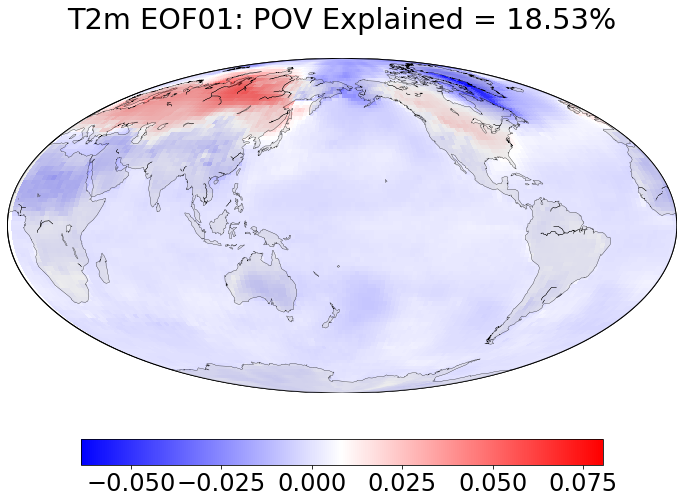

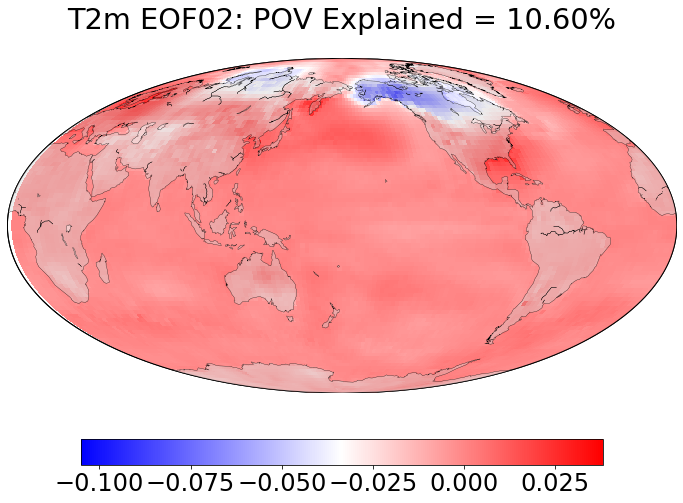

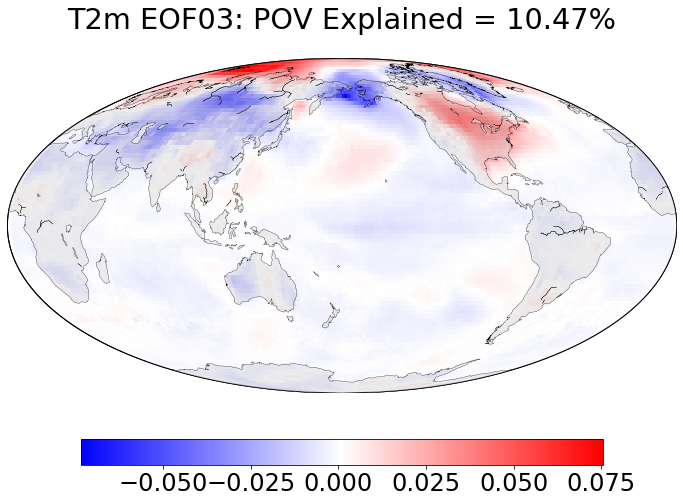

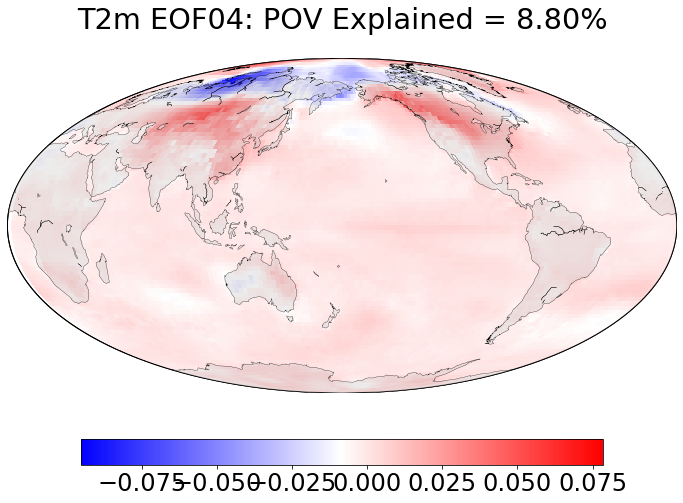

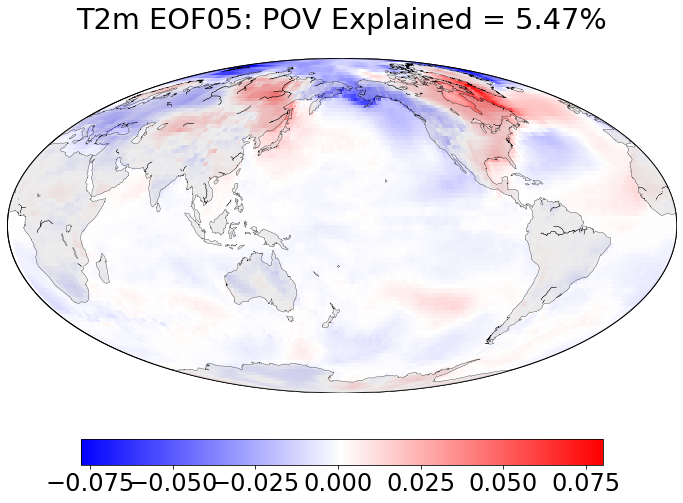

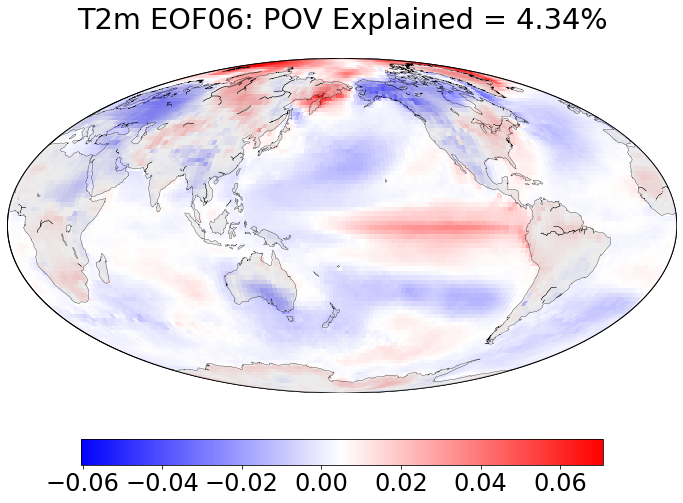

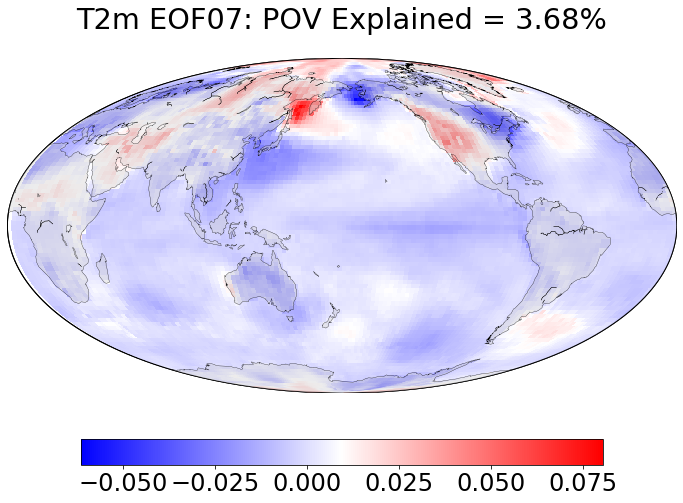

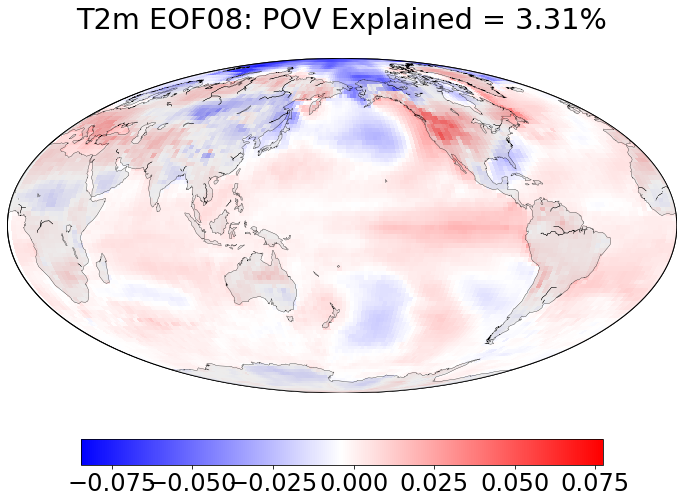

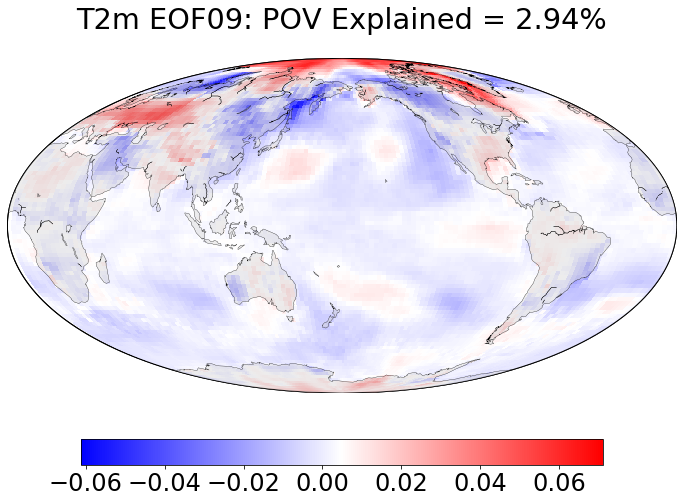

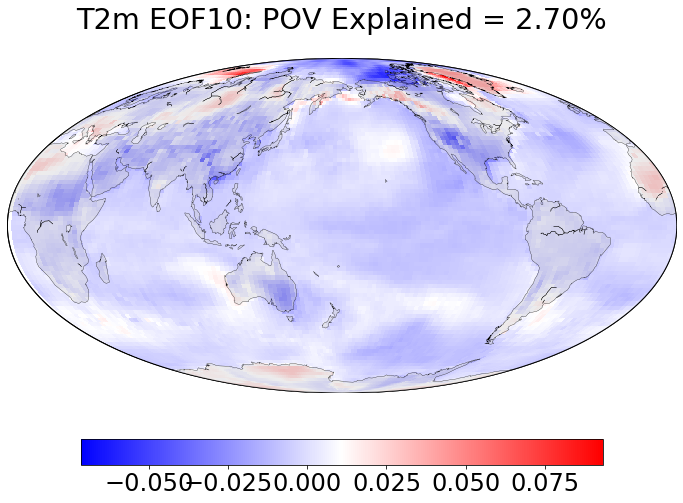

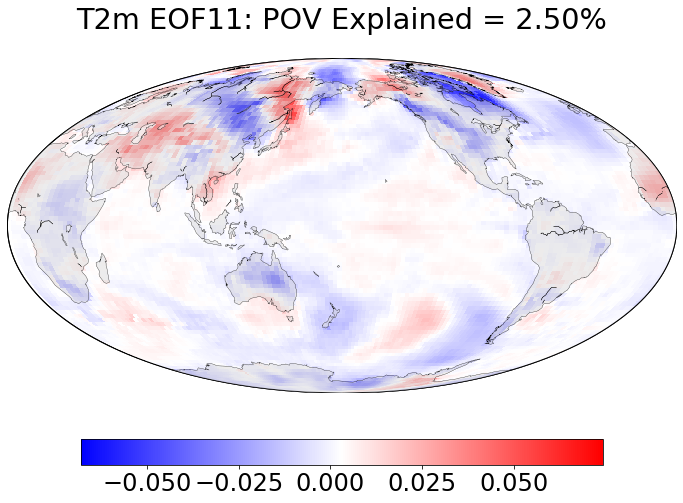

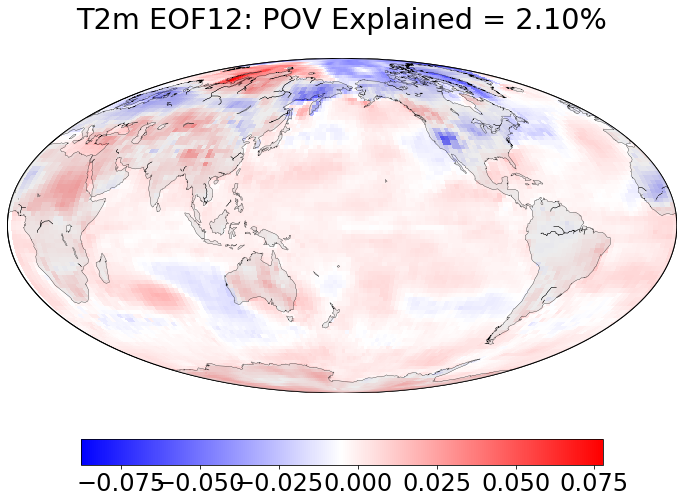

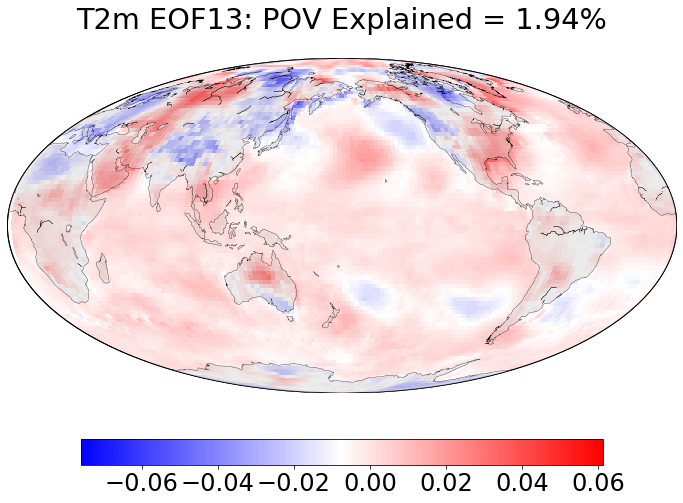

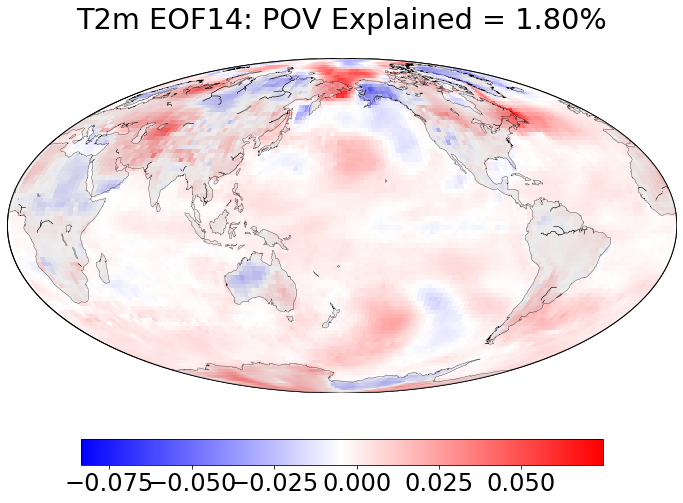

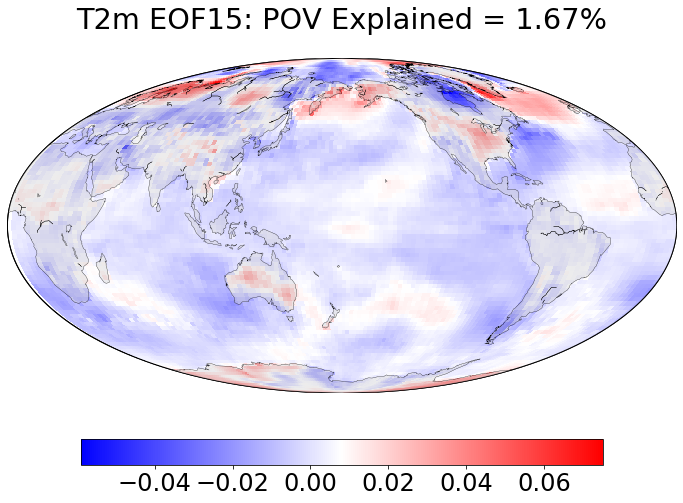

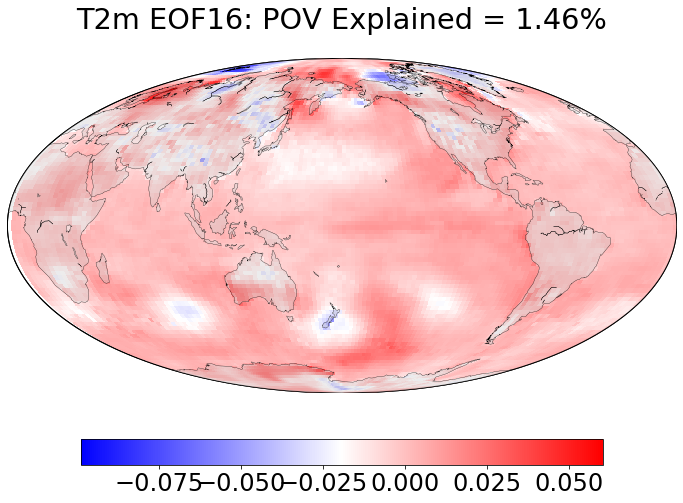

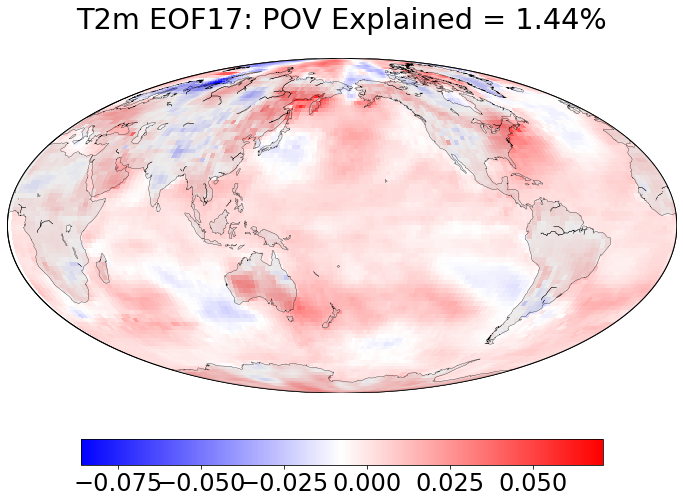

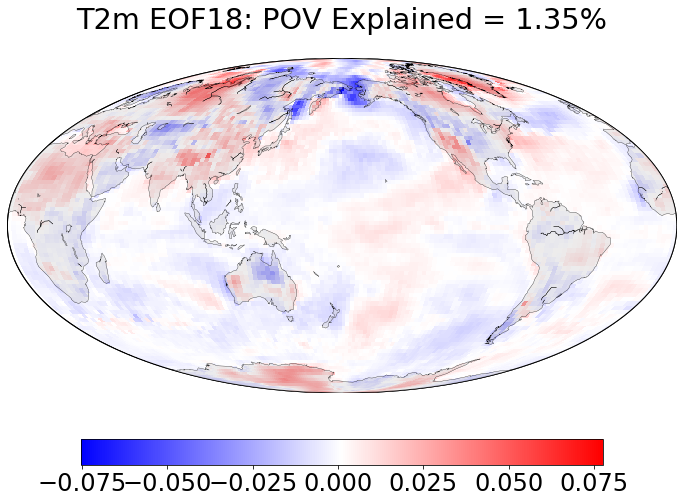

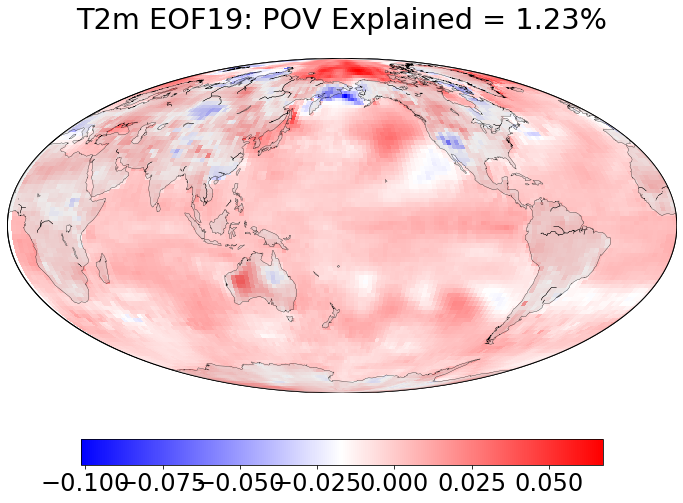

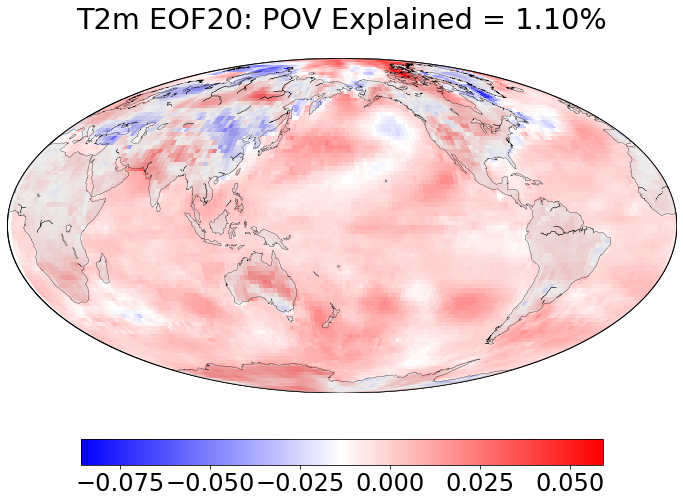

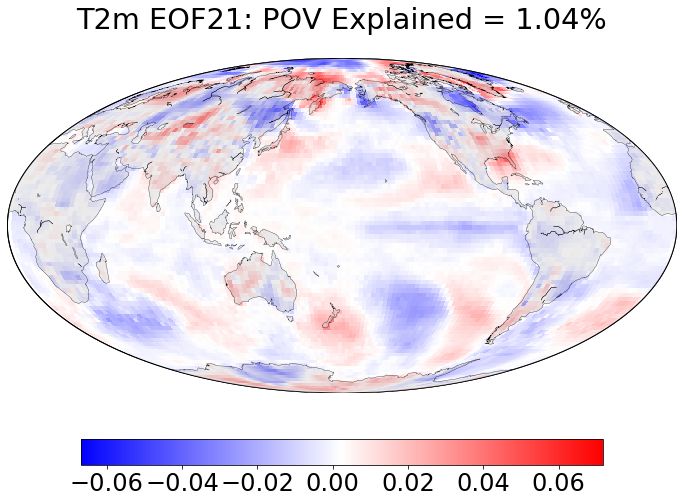

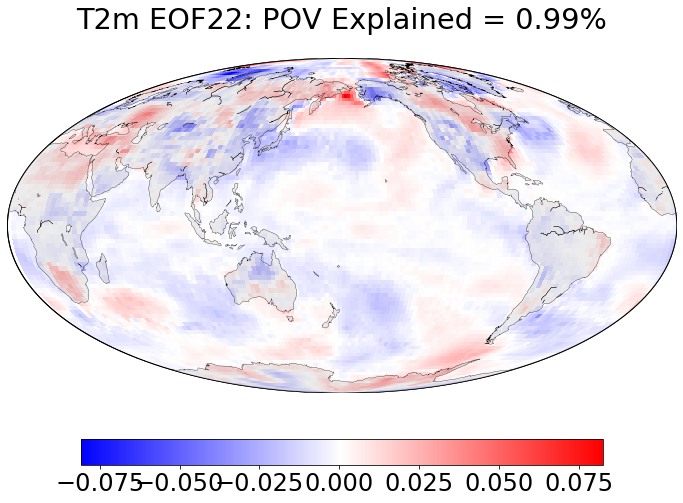

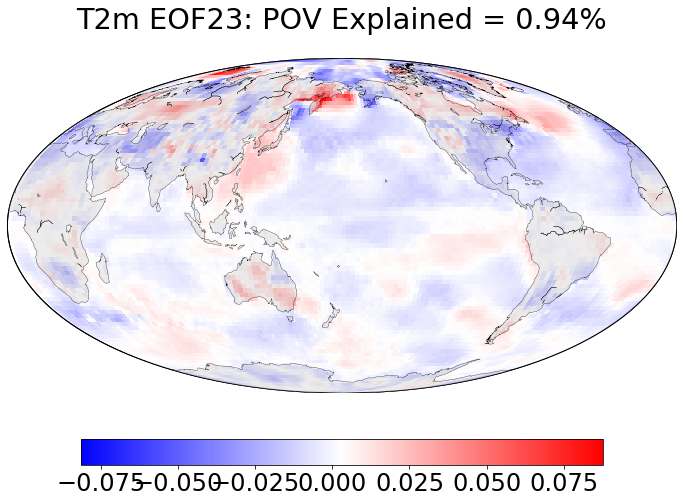

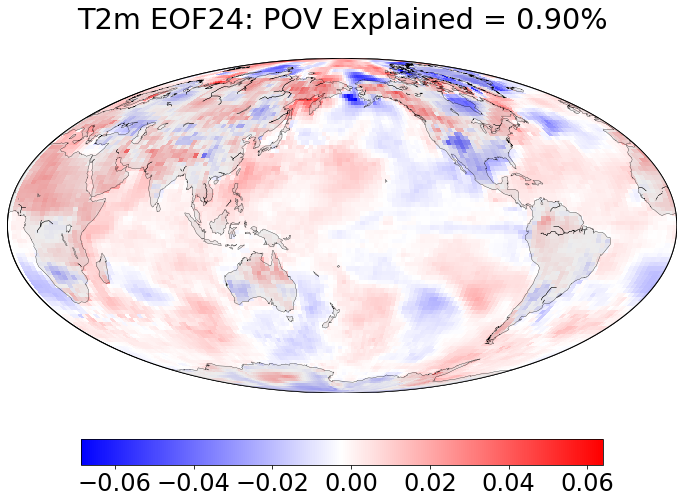

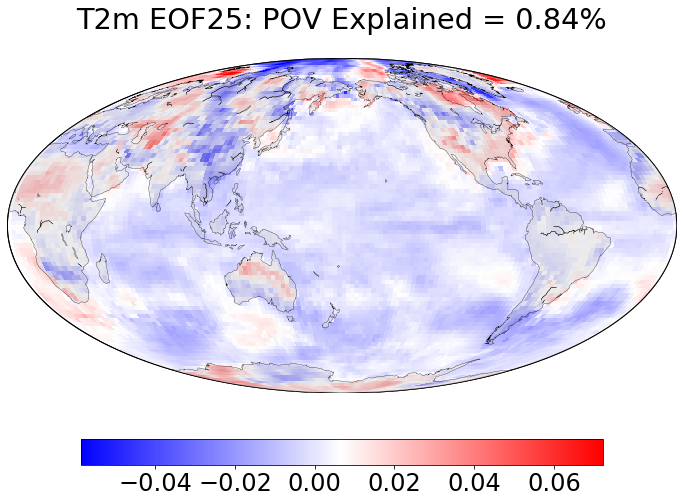

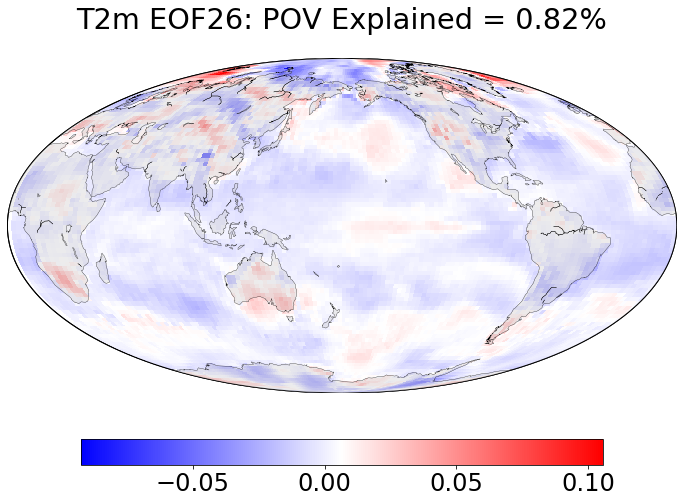

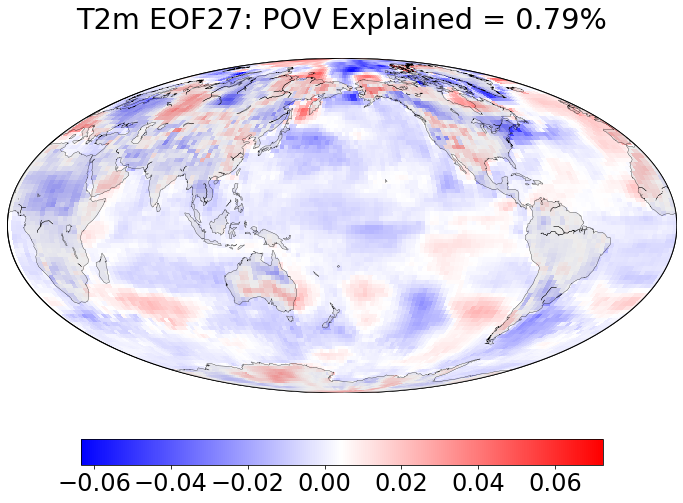

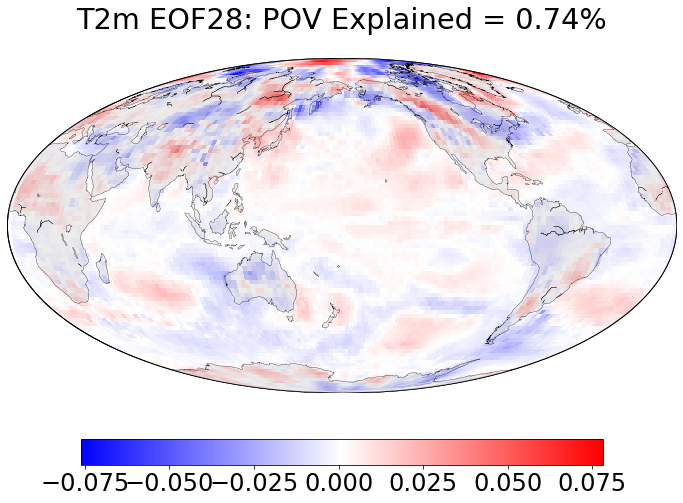

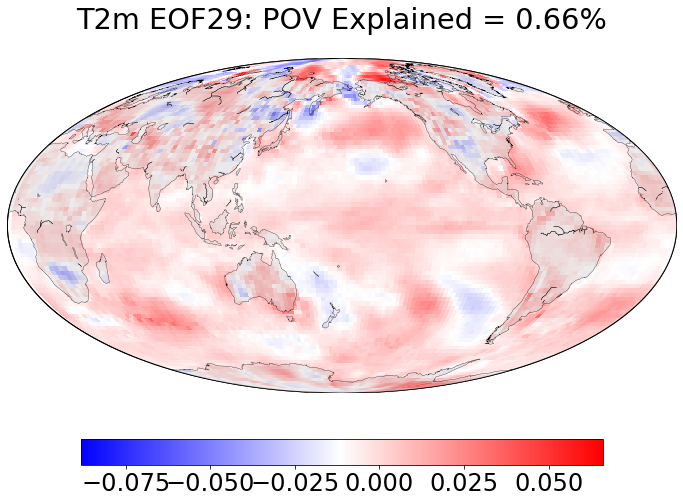

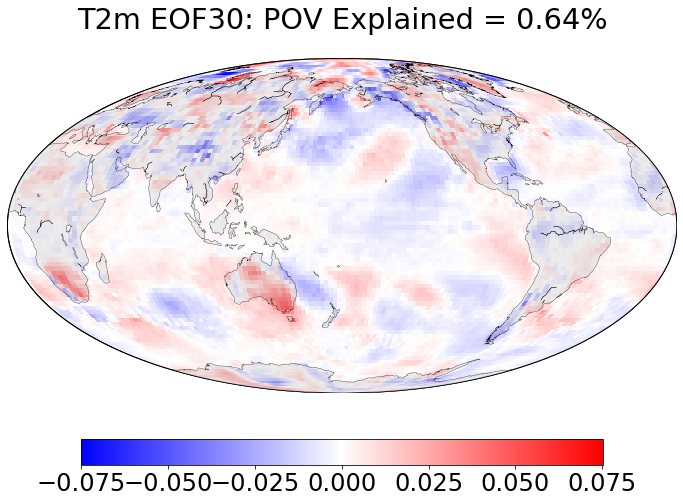

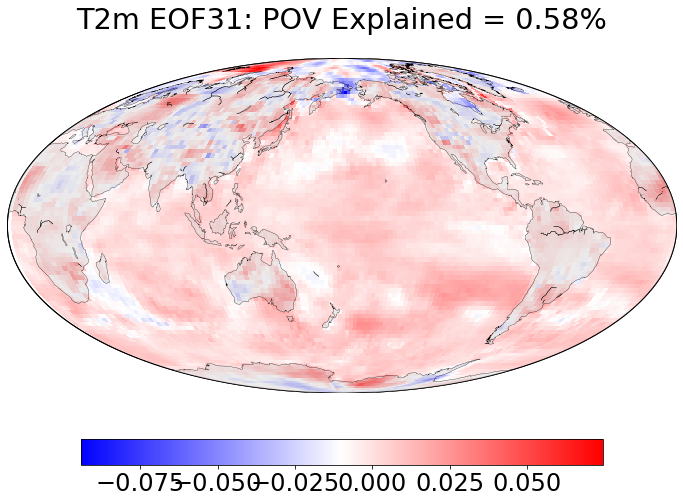

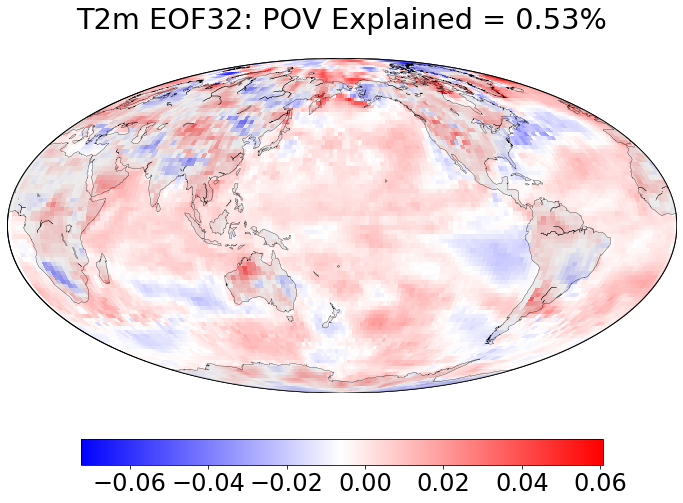

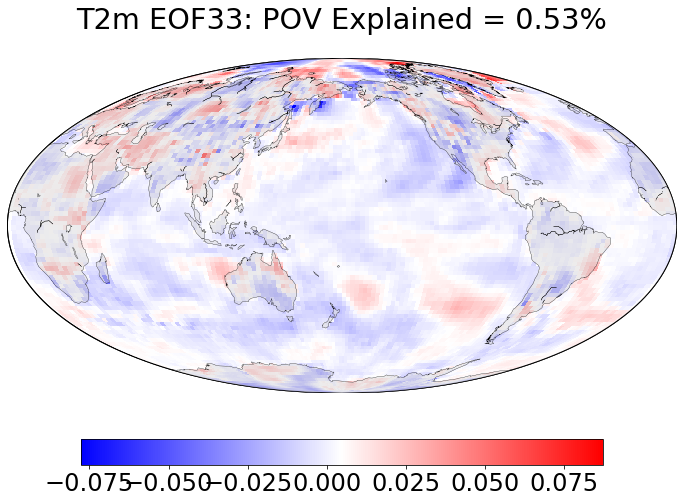

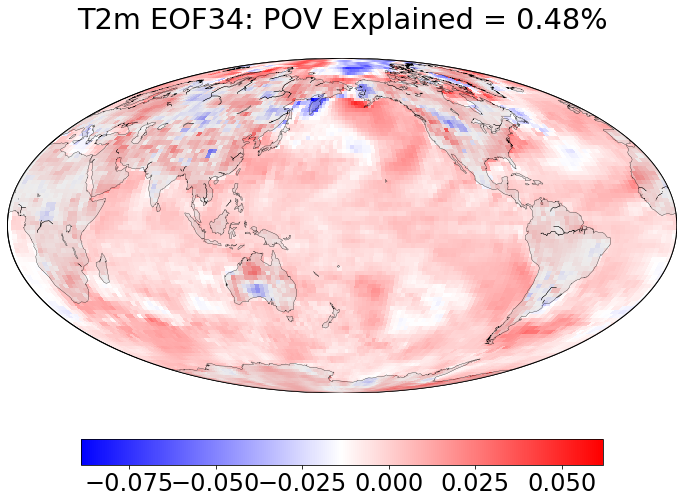

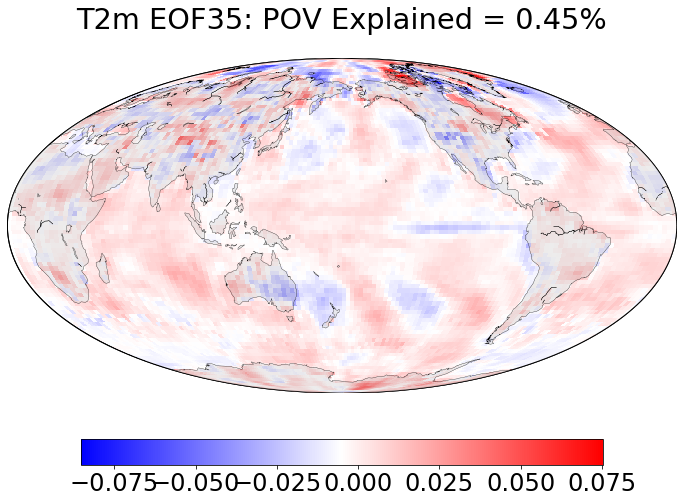

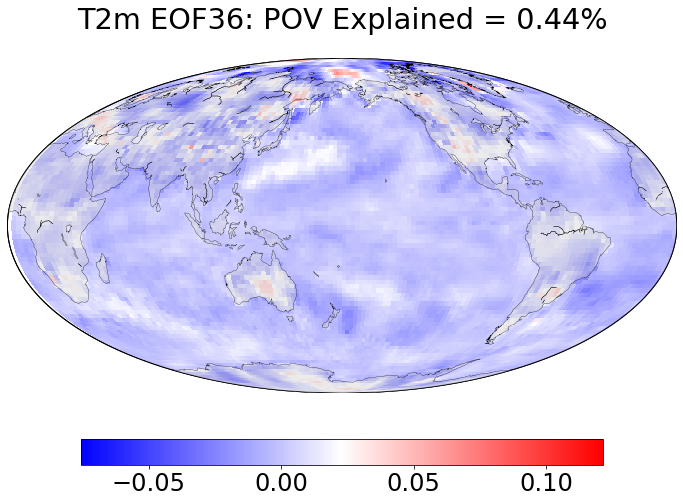

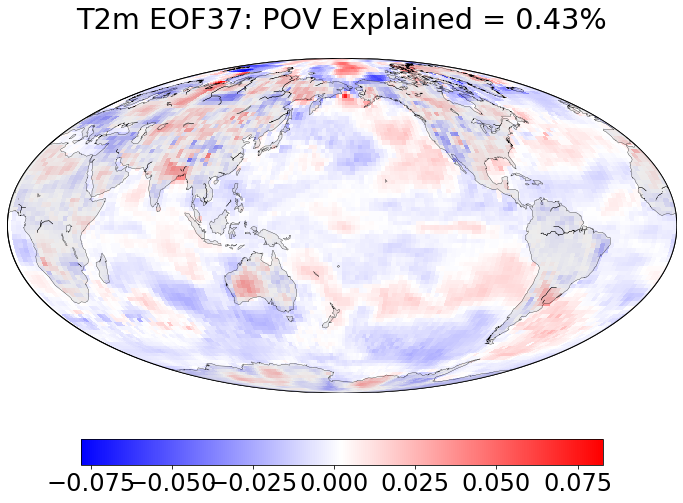

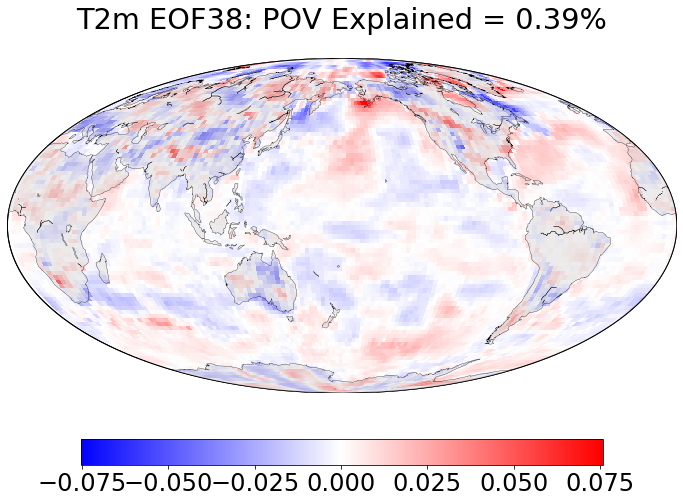

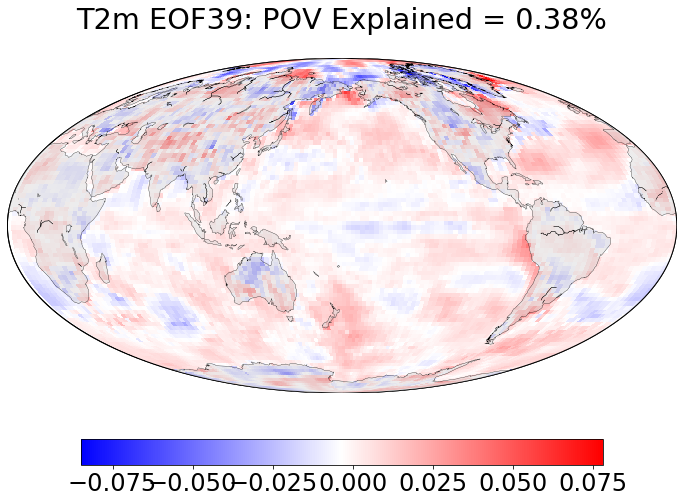

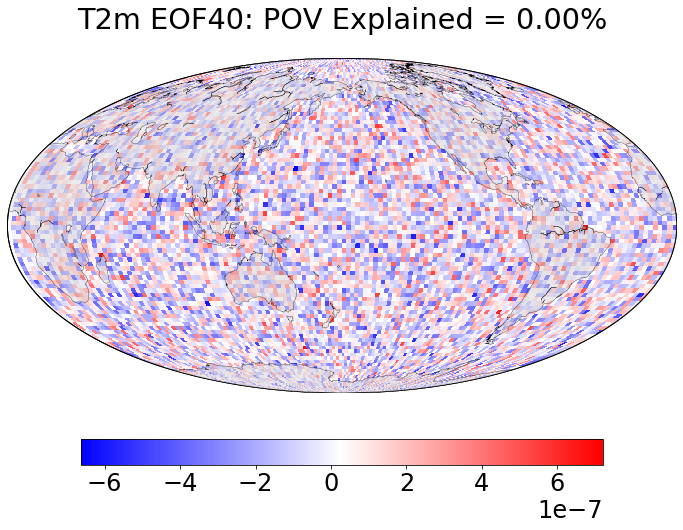

In [11]:
# def get_SST_data():
#     SST = {}
#     months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
#     file = Dataset(‘./ERA5_SST_1x1.nc')
#     data = np.array(file['sst_0001']) - 273.15
#     data[data<0] = np.nan
#     data = data.transpose(1,2,0)
#     SST[‘all_months’] = data
#     for month in range(12):
#         monthly = np.zeros((dimX,dimY,(2019-1979+1)))
#         t = 0
#         for y in range(0,(2019-1979+1)*12,12):
#             monthly[:,:,t] = data[:,:,y+month]
#             t += 1
#         SST[months[month]] = monthly
#     return SST
 
import itertools    

def get_T2m_data():
    T2m = {}
    months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
    file = Dataset('/Users/micheltsamados/Dropbox/WilliamGregory/ERA5_T2m.nc')
    data = np.array(file['t2m_0001'])
    data = data.transpose(1,2,0)
    T2m['all_months'] = data
    for month in range(12):
        monthly = np.zeros((dimX,dimY,(2019-1979+1)))
        t = 0
        for y in range(0,(2019-1979+1)*12,12):
            monthly[:,:,t] = data[:,:,y+month]
            t += 1
        T2m[months[month]] = monthly
    return T2m


def detrend(dataset,dX,dY):
    months = ['jan']
    for month in months:
        data = dataset[month]
        detrended = np.zeros(data.shape) ; detrended[detrended==0] = np.nan
        trend = np.zeros((dX,dY,2)) ; trend[trend==0] = np.nan
        for i,j in itertools.product(range(dX),range(dY)):
            if (~np.isnan(data[i,j,:]).all()) & (max(abs(data[i,j,:])) > 0):
                trendT, interceptT, r_valsT, probT, stderrT = stats.linregress(np.arange(data.shape[2]),data[i,j,:])
                lineT = (trendT*np.arange(data.shape[2])) + interceptT
                trend[i,j,0] = trendT
                trend[i,j,1] = interceptT
                detrended[i,j,:] = data[i,j,:]-lineT

        dataset[month+'_dt'] = detrended
        dataset[month+'_trend'] = trend
            
def EOF(dataset,month):
    data = np.copy(dataset[month+'_dt'])
    data_weighted = np.zeros(data.shape)
    weights = np.sqrt(np.cos(np.radians(lat[:,:])))
#    weights = np.sqrt(np.cos(np.radians(lat[:,:-1])))

    for year in range(1979,2019+1):
        t = year - 1979
        data_weighted[:,:,t] = np.multiply(data[:,:,t],weights[:,:])
    
    data_weighted[np.isnan(data_weighted)] = 0             
    X = data_weighted.ravel().reshape((dimX*dimY),2019-1979+1)
    C = np.dot(X.T,X)
    weights = weights.ravel().reshape(dimX*dimY,1)
    Lambda, PCs = scipy.linalg.eigh(C)
    sigma = np.sqrt(Lambda)
    I = np.eye(len(sigma))*sigma
    EOFs = (np.dot(X,PCs)/sigma)/weights
    total_var = sum(Lambda)
    
    t = 41
    for year in range(1979,2018+1): #this outputs EOF images in order of decreasing explained variance
#    for year in range(1979,2019+1): #this outputs EOF images in order of decreasing explained variance
        tag = (year - 1979) + 1
        t = t - 1
        EOF = EOFs[:,t].reshape(dimX,dimY)
        POV = (Lambda[t]/total_var)*100 #Percentage Of Variance Explained
        fig = plt.figure(figsize=(12,12))
        plt.rcParams.update({'font.size': 24})
        #bwr_50 = cmap_discretize('bwr',51)
        m.drawcoastlines(linewidth=0.3)
        m.fillcontinents(color='lightgrey',lake_color='white',alpha=0.4)
        m.drawmapboundary(fill_color='white')
        m.pcolor(x,y,EOF,cmap='bwr')
        #m.pcolor(x,y,EOF,cmap=bwr_50)
        cbar = plt.colorbar(orientation='horizontal', pad=0.07, fraction=0.04)
        cbar.solids.set_rasterized(True)
        cbar.solids.set_edgecolor("face")
        ttl = plt.title('T2m EOF'+str("%02d"%tag)+': POV Explained = '+str("%.2f"%POV)+'%')
        ttl.set_position([.5,1.07])
        plt.show()

                   
lon = np.arange(0,360,2.5)
lat = np.arange(90,-92,-2)
dimX = len(lat)
dimY = len(lon)
lon,lat = np.meshgrid(lon,lat)
                   
#lon = np.arange(0,361,1)
#lat = np.arange(90,-91,-1)
#dimX = len(lat)
#dimY = len(lon)-1
#lon,lat = np.meshgrid(lon,lat)
#m = Basemap(projection='ortho',lon_0=240,lat_0=0,resolution='l')
#m = Basemap(projection='moll', llcrnrlat=-90, urcrnrlat=90,\
#            llcrnrlon=360, urcrnrlon=0, resolution='c', lon_0=180)
m = Basemap(projection='moll',lon_0=-180,resolution='c')
x,y = m(lon,lat)

T2m = get_T2m_data()
detrend(T2m,dimX,dimY)
EOF(T2m, 'jan')

In [54]:
data[:,:,t].shape

NameError: name 'data' is not defined

In [13]:
#Bug fix for addcyclic
#https://github.com/matplotlib/basemap/blob/master/lib/mpl_toolkits/basemap/__init__.py#L5102
def addcyclic(*arr,**kwargs):
    """
    Adds cyclic (wraparound) points in longitude to one or several arrays,
    the last array being longitudes in degrees. e.g.
   ``data1out, data2out, lonsout = addcyclic(data1,data2,lons)``
    ==============   ====================================================
    Keywords         Description
    ==============   ====================================================
    axis             the dimension representing longitude (default -1,
                     or right-most)
    cyclic           width of periodic domain (default 360)
    ==============   ====================================================
    """
    # get (default) keyword arguments
    axis = kwargs.get('axis',-1)
    cyclic = kwargs.get('cyclic',360)
    # define functions
    def _addcyclic(a):
        """addcyclic function for a single data array"""
        npsel = np.ma if np.ma.is_masked(a) else np
        slicer = [slice(None)] * np.ndim(a)
        try:
            slicer[axis] = slice(0, 1)
        except IndexError:
            raise ValueError('The specified axis does not correspond to an '
                    'array dimension.')
        return npsel.concatenate((a,a[slicer]),axis=axis)
    def _addcyclic_lon(a):
        """addcyclic function for a single longitude array"""
        # select the right numpy functions
        npsel = np.ma if np.ma.is_masked(a) else np
        # get cyclic longitudes
        clon = (np.take(a,[0],axis=axis)
                + cyclic * np.sign(np.diff(np.take(a,[0,-1],axis=axis),axis=axis)))
        # ensure the values do not exceed cyclic
        clonmod = npsel.where(clon<=cyclic,clon,np.mod(clon,cyclic))
        return npsel.concatenate((a,clonmod),axis=axis)
    # process array(s)
    if len(arr) == 1:
        return _addcyclic_lon(arr[-1])
    else:
        return list(map(_addcyclic,arr[:-1])) + [_addcyclic_lon(arr[-1])]

In [14]:
def reverse_colourmap(cmap, name = 'my_cmap_r'):
    """
    In: 
    cmap, name 
    Out:
    my_cmap_r

    Explanation:
    t[0] goes from 0 to 1
    row i:   x  y0  y1 -> t[0] t[1] t[2]
                   /
                  /
    row i+1: x  y0  y1 -> t[n] t[1] t[2]

    so the inverse should do the same:
    row i+1: x  y1  y0 -> 1-t[0] t[2] t[1]
                   /
                  /
    row i:   x  y1  y0 -> 1-t[n] t[2] t[1]
    """        
    reverse = []
    k = []   

    for key in cmap._segmentdata:    
        k.append(key)
        channel = cmap._segmentdata[key]
        data = []

        for t in channel:                    
            data.append((1-t[0],t[2],t[1]))            
        reverse.append(sorted(data))    

    LinearL = dict(zip(k,reverse))
    my_cmap_r = mpl.colors.LinearSegmentedColormap(name, LinearL) 
    return my_cmap_r

In [37]:
##############################################################################################
# Function to calculate the spatial mean of one field and write the trends in .dat files
# returns
#          ---> trend_time[year]
#          ---> trend_space[x,y]
##############################################################################################

def cal_trend(start_year, num_years, start_month, num_months, nx, ny, var):

# Initialize
        x = nx
        y = ny

##################
# Maps of trends
##################

# Monthly averaged
        num_years
        years = np.arange(num_years)
        trend_ym = np.zeros((num_months, x, y))
        sig_a_ym = np.zeros((num_months, x, y))
        r_a_ym = np.zeros((num_months, x, y))
        int_a_ym = np.zeros((num_months, x, y))

        for month in range(num_months):
                print (month)
                var_y = np.mean(var,1)
                for i in range(x):
                        for j in range(y):
                                slope, intercept, r, prob, stderr = stats.linregress(years,var[start_year:start_year+num_years, month, i, j])
                                trend_ym[month, i, j] = slope
                                sig_a_ym[month, i, j] = 100*(1-prob)
                                r_a_ym[month, i, j] = r
                                int_a_ym[month, i, j] = intercept

# Yearly averaged
        years = np.arange(num_years)
        trend = np.zeros((x, y))
        sig_a = np.zeros((x, y))
        r_a = np.zeros((x, y))
        int_a = np.zeros((x, y))

        for i in range(x):
                for j in range(y):
                        slope, intercept, r, prob, stderr = stats.linregress(years,var_y[start_year:start_year+num_years, i, j])
                        trend[i, j] = slope
                        sig_a[i, j] = 100*(1-prob)
                        r_a[i, j] = r
                        int_a[i, j] = intercept

        return trend, trend_ym, sig_a, sig_a_ym, r_a, r_a_ym, int_a, int_a_ym



In [25]:
! pwd

/Users/micheltsamados/Dropbox/FerhatYilmaz


In [ ]:
#Interpolate on ERA-I grid
#mapC = Basemap(projection='stere', lon_0=-45, lat_0=90, lat_ts=70, 
#        urcrnrlat=31.37 , urcrnrlon=102.34, llcrnrlat=33.92,  llcrnrlon=279.26)
m = Basemap(width=4000000,height=2000000,
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',area_thresh=1000.,projection='lcc',\
            lat_1=30.,lat_2=40,lat_0=35,lon_0=39.)
t=0
lon, lat = np.meshgrid(moda[0]['longitude'],moda[0]['latitude'])
t2m_out,lat_out,lon_out=addcyclic(t2m_array[t][::-1,:],lat[::-1,:],lon[::-1,:])
x, y = m(lon_out, lat_out)
#depth_ERAI_nn=griddata((xtest.ravel(), ytest.ravel()),depth.ravel(), (x, y), method='nearest')